In [1]:
# 1. Ar + Master list
# 2. expm = e^(itAlambda) = S
# 3. S^2 = Ig -> GP -> Ug
# use weak beam approximation after it works

# program: qeda: 'Quantitative Electron Diffraction Analysis' 

    # First we read/create in the experimental conditions.
    # We need: 
    # - the microscope parameters (high tension)
    # - the (indexed) reciprocal lattice
    # - the zone axis
    # - the array of kt-vectors (this could also be defined as equally spaced, with some maximum value)
    # 
    # There are 2 options for this code: 
    # a) compute a LARBED pattern (requires knowledge of crystal structure)
    # b) analyze an experimental data set (requires measured intensities and spot positions)
    # We should first complete a), because we can then use that as input to b)
    ############################################/
#%%
import os
import pyQEDA as pq #note this python source file/jupyter notebook should not be called 'pyQEDA.py' as this is reserved for the pyQEDA module as will cause a conflict if named so
import numpy as np
import requests
import math
import matplotlib.pyplot as plt
currentPath = os.getcwd()
import sys


sys.path.append("/Users/chenjie/pyQEDA/pyscripts")
import pyQEDA_function
#import pyQEDA_potential as pqp
import pyQEDA_potential_CTK as pqp
import normalization_function as nf
import makeUniqueUgVector_cj as mu
import makeUniqueUgVector_3D_cj as mu_3D

In [2]:
File = "ZnO_001_Th500A_T30mrad_r8_maxg_0_5_100kV.qed"
file = "ZnO_001_Th500A_T30mrad_r8_maxg_0_5_100kV"
#enter the QEDA parameter file here (including filetype)
filename = currentPath + "/Jie_parameter_files/" + File
cfgFolder="/crystal_files/" #these input and output folders are appended to the beginnng of the string read from the .qed file
outputFolder="/pyQEDA_simulations/"
#imageFolder="/pyQEDA_simulations/" #these input and output folders are appended to the beginnng of the string read from the .qed file
#if using experimental intensities
expImageFolder = "/experimental_data/"
expImageFolder = currentPath + expImageFolder
#traing Data(Pattern Folder & Ug Folder)
trainingFolder = "/training_Data/"
trainingFolder = currentPath + "/training_Data/"

In [3]:
#%% Default parameters if no input file is available

# Let's start with a few settings:
computeTermMaps = 0
############################################/
# Here are a few default parameters which should be overwritten by an input data file:


n = ([0.0,0.0,1.0]) #surface normal (surface slab normal points against the beam)
zone = ([0.0,0.0,1.0]) #which zone axis (crystal orientation)
gx = ([1.0,0.0,0.0])    #the g vector
ktOffset = ([0.0,0.0])
highTension = 120    #the electron bean energy in kV
gCutoff = 2.5      # cut off reflections at 3 1/A
sgCutoff    = 0.025; # select reflections that are closer than 0.2 1/A to the Ewald sphere.
thickness   = 130.0; # thickness in A.
scanComp    = 0.0; #scan compensation can be used to descan the beam to ensure there are no overlapping beams, (with full scan compensation there is no rocking curve, only integrated spots)
detectorNx  = 700 #size of the detector
detectorNy  = detectorNx
tiltRange_mrad = 40 
discRadius_pixel = 3  #the scan pattern is a disc, this parameter chooses how many scan points to fit in one radius and the total scan points is then calculated to fit inside the disc.
q , approxOrder = 0, 0
termThresh = 0.0001 
targetUg = 0.01


Generate_random_diffs = False
UseInputUgMasterList = False

if UseInputUgMasterList:
    Generate_random_diffs = False #dont use both at the same time

elif Generate_random_diffs: 
    N_training_data = 140 #How many times to run the simulation. Right now, it outputs random Ug vectors on every run. These can be used to train a Neural network.
    RandomUgMasterList = []
    random_diffs = []
else:
    diff_pattern = []
    N_training_data = 1

/Users/chenjie/pyQEDA/pyQEDA_simulations/ZnO_001_Th500A_T30mrad_r8_maxg_0_5_100kV/ZnO_001_Th500A_T30mrad_r8_maxg_0_5_100kV_experimental_data/_BeamList.txt
(0.128513+0j)
(8.60688e-10-2.64943e-09j)
(8.60688e-10+2.64943e-09j)
(-0.0412296+2.45748e-09j)
(0.012793-0.0326027j)
(-0.012793-0.0326027j)
(-0.0412296-2.45748e-09j)
(-0.012793+0.0326027j)
(0.012793+0.0326027j)
(-0.0412267+2.45731e-09j)
(-0.0127923+0.0326005j)
(0.0127923+0.0326005j)
(-0.0412271+0j)
(0.0127922-0.0326004j)
(-0.0127922-0.0326004j)
(-0.0412267-2.45731e-09j)
(0.0127923-0.0326005j)
(-0.0412271+0j)
(-0.0127922+0.0326004j)
(0.0577454+0.0224833j)
(-0.0226861-0.00887843j)
(-0.0226861-0.00887842j)
(-0.0226851-0.008878j)
(-0.0226853-0.0088781j)
(-0.0127923-0.0326005j)
(0.0127922+0.0326004j)
(0.0577454-0.0224833j)
(-0.0226861+0.00887842j)
(-0.0226861+0.00887843j)
(-0.0226851+0.00887801j)
(-0.0226853+0.0088781j)
(-0.0226851+0.008878j)
(-0.0226853+0.0088781j)
(-0.022702-1.35314e-09j)
(0.00698086-0.0198148j)
(-0.00698086-0.0198148j)


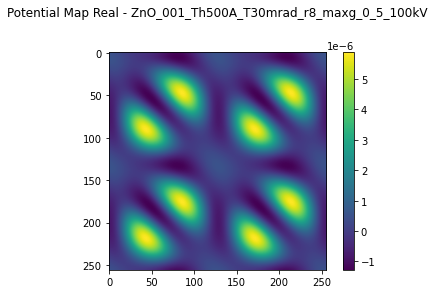

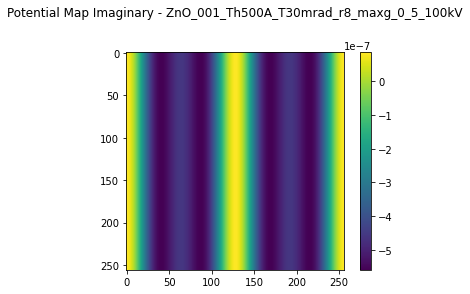

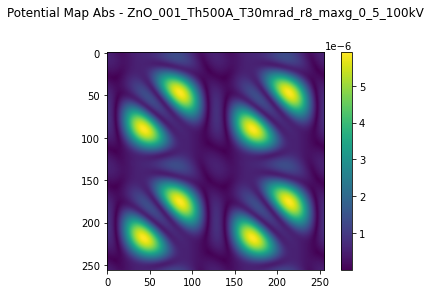

In [4]:
#This function has 2 versions run from a folder or from InputUg and InputBeams 
# It displays the potential from the simulation with an option to charge flip below a threshold 
# When run from a folder, beams are also output which is necessary for running in the other mode. 
# The order should be 
# 1. run pyQEDA simulation normally with no random Ug (and do not run this cell yet)
# 2. run this this function like this to get beams as a variable (alternatively you could write another function that just reads the BeamList.txt file)
# 3. run the notebook with generate_random_diffs = True. This will generate random Ug, charge flip them, then use the flipped Ug as input. This creates more realistic intensities.
[UgList0, potMapExp, beams] = pqp.displayPotentialFromUg(folder=file,\
                                                          potSize=([256,256]), \
                                                          Ncells=([2,2]),     \
                                                          showImag=True,      \
                                                          doFlip=False,       \
                                                          thresh = 0.1,     \
                                                          beta = 0.9,\
                                                         InputUg=None,\
                                                         InputBeams=None,\
                                                         returnComplexUg=False,\
                                                         scaling=1,\
                                                         scaleImag=0)

In [5]:
def read_parameter_file(filename,training_data):    
    with open(filename, "r") as f:
        for line in f:
            if 'mode:' in line:
                mode = line[line.index(':')+1:-1].strip(' ')
                print(f"mode = \t\t{mode}") 
            if 'cfg file:' in line:
                cfgName = currentPath + cfgFolder + line[line.index(':')+1:-1].strip(' ')
                print(f"cfg file = \t\t{cfgName}") 
            if 'output folder:' in line:
                outputName = line[line.index(':')+1:-1].strip(' ')
                if Generate_random_diffs:
                    outputPath = currentPath + outputFolder + "/" + outputName + "/" + outputName + "_training_data_" + str(training_data)
                elif UseInputUgMasterList:
                    outputPath = currentPath + outputFolder + "/" + outputName + "/" + outputName
                else:
                    outputPath = currentPath + outputFolder + "/" + outputName + "/" + outputName + "_experimental_data"
                print(f"created output folder = \t\t{outputFolder}")
                if os.path.exists(outputPath):
                    print("file exists")
                else:
                    pass
                    os.makedirs( outputPath )
            if 'output file:' in line:
                imageName = line[line.index(':')+1:-1].strip(' ') 
                if Generate_random_diffs:
                    imagePath = currentPath + outputFolder + "/" + outputName + "/" + outputName + "_training_data_" + str(training_data) + "/" + imageName                          
                elif UseInputUgMasterList:
                    imagePath = currentPath + outputFolder + "/" + outputName + "/" + outputName + "/" + imageName
                else:
                    imagePath = currentPath + outputFolder + "/" + outputName + "/" + outputName + "_experimental_data" + "/" + imageName
                print(f"output file = \t\t{imagePath}")    
            if 'zone axis:' in line:
                zone = line[line.index(':')+1:-1].strip(' ')
                zone = list(zone.split(" "))
                zone = [float(i) for i in zone]
                print(f"zone axis= \t\t{zone}") 
            if 'gx vector:' in line:
                gx = line[line.index(':')+1:-1].strip(' ')
                gx = list(gx.split(" "))
                gx = [float(i) for i in gx]
                print(f"gx vector= \t\t{gx}")
            if 'surface normal:' in line:
                n = line[line.index(':')+1:-1].strip(' ')
                n = list(n.split(" "))
                n = [float(i) for i in n]
                print(f"surface normal = \t\t{n}")           
            if 'tilt offset (mrad):' in line:
                ktOffset = line[line.index(':')+1:-1].strip(' ')
                ktOffset = list(ktOffset.split(" "))
                ktOffset = [float(i) for i in ktOffset]
                print(f"tilt offset (mrad) = \t\t{ktOffset}") 
            #% Parameters for scattering path approximation
            if 'approximation:' in line:    # 0=Bloch wave, 1=kinematic, >1=Scatt. patch expansion
                approxOrder = line[line.index(':')+1:-1].strip(' ')
                approxOrder = int(approxOrder.split("%")[0].strip('\t').strip(' '))
                print(f"approximation = \t\t{approxOrder}")
            if 'term threshold:' in line:   # fraction of total intensity above which to include a term
                termThresh = line[line.index(':')+1:-1].strip(' ')
                termThresh = float(termThresh.split("%")[0].strip('\t').strip(' '))
                print(f"term threshold = \t\t{termThresh}") 
            if 'target Ug:' in line:   #  maximum value expected for any Ug (only used for term selection)
                targetUg = line[line.index(':')+1:-1].strip(' ')
                targetUg = float(targetUg.split("%")[0].strip('\t').strip(' '))
                print(f"target Ug = \t\t{targetUg}")
            if 'high tension:' in line:   #  maximum value expected for any Ug (only used for term selection)
                highTension = line[line.index(':')+1:-1].strip(' ')
                highTension = float(highTension.split("%")[0].strip('\t').strip(' '))
                print(f"high tension = \t\t{highTension}")
            if 'max g vector:' in line:   # gCutoff in 1/A.
                gCutoff = line[line.index(':')+1:-1].strip(' ')
                gCutoff = float(gCutoff.split("%")[0].strip('\t').strip(' '))
                print(f"max g vector = \t\t{gCutoff}")
            if 'max sg:' in line:   # sgCutoff, selects reflections that are closer than 0.02 1/A to the Ewald sphere.
                sgCutoff = line[line.index(':')+1:-1].strip(' ')
                sgCutoff = float(sgCutoff.split("%")[0].strip('\t').strip(' '))
                print(f"max sg = \t\t{sgCutoff}") 
            if 'thickness:' in line:   # thickness in A
                thickness = line[line.index(':')+1:-1].strip(' ')
                thickness =  float(thickness.split("%")[0].strip('\t').strip(' '))
                print(f"thickness = \t\t{thickness}")
            if 'scan compensation:' in line:   #scan Compensation as in the QED acquisition
                scanComp = line[line.index(':')+1:-1].strip(' ')
                scanComp =  float(scanComp.split("%")[0].strip('\t').strip(' '))
                print(f"scan compensation = \t\t{scanComp}")
            if 'tilt range (mrad):' in line:   
                tiltRange_mrad = line[line.index(':')+1:-1].strip(' ')
                tiltRange_mrad =  float(tiltRange_mrad.split("%")[0].strip('\t').strip(' '))
                print(f"tilt range (mrads) = \t\t{tiltRange_mrad}")
            if 'disc radius (pixels):' in line:   #disc diameter will be di = 2ri+1
                discRadius_pixel = line[line.index(':')+1:-1].strip(' ')
                discRadius_pixel =  int(discRadius_pixel.split("%")[0].strip('\t').strip(' '))
                print(f"disc radius (pixels) = \t\t{discRadius_pixel}")
            if 'detector size x:' in line: 
                detectorNx = line[line.index(':')+1:-1].strip(' ')
                detectorNx =  int(detectorNx.split("%")[0].strip('\t').strip(' '))
                detectorNy = detectorNx
                print(f"detector size x = \t\t{detectorNx}")
                
    return mode,cfgName,outputName,outputPath,imageName,imagePath,zone,gx,n,ktOffset,approxOrder,termThresh,highTension,gCutoff,sgCutoff,thickness,scanComp,tiltRange_mrad,discRadius_pixel,detectorNx,detectorNy




In [6]:
if Generate_random_diffs: 
    RandomUgMasterList = []
    random_thickness = []
    UgLists = []
    random_diffs = []
    Ug_normalized_matrix = []
    DoFlip = False
    MakeUniqueUg = False
else:
    diff_pattern = []
    N_training_data = 1

mode = 'LARBED_SIM' #LARBED_SIM by default

for training_data in range(N_training_data):
    print(f'\niteration={training_data}')

    if mode == 'LARBED_SIM':
        
        #read the parameter file which assigns the relevant variables
        mode,cfgName,outputName,outputPath,imageName,imagePath,zone,gx,n,ktOffset,approxOrder,termThresh, \
        highTension,gCutoff,sgCutoff,thickness,scanComp,tiltRange_mrad,discRadius_pixel,detectorNx,detectorNy \
        = read_parameter_file(filename,training_data)
        
        # read the crystal structure from a .cfg file:
        Xtal = pq.Crystal(cfgName)

        print(f"\n* QEDA: Simulation of {cfgName}, zone = {zone}\n")
        ############################################/
        # Now we can allocate and initialize the pattern collection (e.g. LARBED data set).
        # This also assigns it the crystal object containing lattice parameters, etc.
        # dataSet = pq.PatternCollection(Xtal,highTension,zone,n,gx,gCutoff,sgCutoff)
        dataSet = pq.PatternCollection(Xtal,highTension,zone,n,gx,gCutoff,sgCutoff)
        
        #   # If we want to do simulations we can automatically create a disc pattern with a certain radius
        #   # and a given number of pixels spanning the radius:
        dataSet.GenerateDisc( tiltRange_mrad , discRadius_pixel , ktOffset)

        # For curiosity, we can look how many beams have been selected for each pattern
        dataSet.PrintTilts()
        #dataSet.CreateBeamCountMap()
        nBeamsTotal = dataSet.CreateUgMasterList()
        
        if Generate_random_diffs:
            thickness = np.random.randint(50,1000)
            #thickness = 150
            print(f'thickness={thickness}')
            random_thickness.append(thickness)
            
            #generate a list of random Ug
            #RandomUgMasterList.append( dataSet.ComputeRandomUgMasterList() ) #this random set of Ug is generated (useful for ML training)
            
            
            RandomUgMasterList.append( dataSet.GetRandomUgMasterList(0.2,0.4) )#Sherjeel implementation of random vectors(similar but with Ug limits
            print(f'\n\nRandom Ug List {training_data} = \n\n{RandomUgMasterList[training_data]}\n')
            
            if DoFlip == True:
                #select this iteration Ug and change from complex to alternative real,imag,real,imag....
                InputUg = np.asarray(RandomUgMasterList[training_data])
                InputUg = np.ravel([InputUg.real,InputUg.imag],'F')
            
                #This function takes in a set of Ug and beams (beams need to be defined this is why the function is run  near the beginning)                   
                #It converts Ug -> potential map and *(-1) values below the defined threshold then -> Ug and is output as a complex list. Also available is the potential map output
                [UgList, potMapSim] = pqp.displayPotentialFromUg(folder=File,\
                                       potSize=([256,256]), \
                                       Ncells=([2,2]),     \
                                       showImag=True,      \
                                       doFlip=True,       \
                                       thresh = 0.01,     \
                                       beta = 0.9,\
                                       InputUg=InputUg,\
                                       InputBeams = beams, \
                                       returnComplexUg=True,\
                                       scaling=1)
                        
                #This 'charge flipped' Ug list is then used in the diffraction simulation
                UgLists.append(UgList)
                origin_Ug = UgLists[training_data]
                #dataSet.UseInputUgMasterList(UgList)
            else:
                origin_Ug = RandomUgMasterList[training_data]
                            

            #filepath = "/Users/chenjie/pyQEDA/pyQEDA_simulations/" + outputName + "/" + outputName + "_experimental_data" +'/'
            #beamfilename = '_BeamList.txt'
            #beamfile = filepath + beamfilename
            #beams = np.asarray(np.loadtxt(beamfile,skiprows=1, usecols= range(1, 4)  ), dtype=int )
            
            Ug_normalized = nf.normalization(file = file, origin_Ug=origin_Ug)
            
            if MakeUniqueUg == True:
                
                UgUnique, r0 = mu.makeUniqueUgVector(Ug_normalized,1,6,file = file)
                #print("Applied shift of unit cell origin (fractional coordinates):",r0[0],r0[1])
                #for j in range(beams.shape[0]):
                #    print("Ug[",j,"]:",np.round(np.abs(Ug_normalized[j]),5),np.round(np.angle(Ug_normalized[j]),5),
                #          " => ",np.round(np.abs(UgUnique[j]),5),np.round(np.angle(UgUnique[j]),5))
                
                Ug_normalized = UgUnique
                                                                        
            Ug_normalized_matrix.append(Ug_normalized)
            dataSet.UseInputUgMasterList(Ug_normalized)
            
            print(f'Ug_normalized:\n{Ug_normalized}\n')
            dataSet.PrintUgMasterListVoid()
            

        elif UseInputUgMasterList:
            InputUgRaw = np.loadtxt("/Users/chenjie/pyQEDA/training_Data/predicted_ug_t_test.csv")
            InputUg = np.array(range( np.int((InputUgRaw.size - 1)/2) ), dtype=complex)
            thickness = InputUgRaw[-1] * 1000
            InputUg.real = InputUgRaw[0:-1:2] 
            InputUg.imag = InputUgRaw[1:-1:2]
            print(f"thickness={thickness}")    
            print(f"InputUg = {InputUg.shape}")

            #Can do charge flipping here also if you like this will charge flip input Ug values (e.g Neural Network)
#             [UgList, potMapSim] = pqp.displayPotentialFromUg(folder=None,\
#                                                       potSize=([256,256]), \
#                                                       Ncells=([2,2]),     \
#                                                       showImag=True,      \
#                                                       doFlip=True,       \
#                                                       thresh = 0.01,     \
#                                                       beta = 0.9,\
#                                                       InputUg=np.ravel([InputUg.real,InputUg.imag],'F'),\
#                                                       InputBeams = beams, \
#                                                       returnComplexUg=True,\
#                                                       scaling=1)

            dataSet.UseInputUgMasterList(InputUg)
            print(f'InputUg:\n{InputUg}\n')
            dataSet.PrintUgMasterListVoid()
            
        else:
            # Next, we can generate the structure factor master list
            nBeamsTotal = dataSet.CreateUgMasterList()
            print(f"\n\nAll patterns together contain {nBeamsTotal} different beams\n")
            dataSet.ComputeUgMasterList()      #for a normal simulation this would be used instead of generating a random set of Ug
            dataSet.PrintUgMasterListVoid()
    

        # if we use the scattering path expansion, then convergence will be slowed down by the large value of U0.
        # We therefore simply set U0 to zero:
#         if approxOrder !=  0:
#             dataSet.resetU0()
#             if computeTermMaps == 1:
#                 for q in range(1,abs(approxOrder)):
#                     dataSet.ComputeDiffraction(thickness,-q,termThresh,targetUg)
#                     print(f"{mapName},termMap_q={q}.img")
#                     if Generate_random_diffs:
#                         random_diffs.append(dataSet.CreateDiffPat(mapName,detectorNx,detectorNy,scanComp) ) 
#                     else:
#                         diff_pattern.append( dataSet.CreateDiffPat(mapName,detectorNx,detectorNy,scanComp) )          

        # # for debugging purposes only:
        #dataSet.PrintUgMasterListVoid()
        
        if (approxOrder >= 0):
            # And now, we can start the dynamical calculation.
            dataSet.ComputeDiffraction(thickness,approxOrder,termThresh,targetUg)

            # # Let's save the data in binary format, so that we can analyze it later:
            dataSet.SaveDiffractionIntensities( imagePath )


            # # Finally, we ant to display the pattern.
            if Generate_random_diffs:
                random_diffs.append( dataSet.CreateDiffPat( detectorNx,detectorNy,scanComp) ) #this returns a variable of the diffraction pattern
            else:        
                diff_pattern.append( dataSet.CreateDiffPat( detectorNx,detectorNy,scanComp) ) #there is also a function to save to file


        # write all the simulated intensities, matrix diagonals, and Ar's to disk 
        dataSet.WriteSimulationParameters(outputPath)
        dataSet.PrintUgMasterList(outputPath  + "/_BeamList.txt" , 1)
        dataSet.PrintUgMasterList(outputPath  + "/_UgMasterList.txt" , 0)

        ###############################################/
        # let's also fit kinematic rocking curves to get a first estimate of the structure factors:
        # First, we need to load the experimental data:
        dataSet.LoadDiffractionIntensities( imagePath  )
        nBeamsTotal = dataSet.CreateUgMasterList()
        print(f"\nAll patterns together contain {nBeamsTotal} different beams\n")
        # Now, we can fit the diffraction data, first with kinematic theory, 
        # then with higher order approximations to dynamical theory: 
        # This function will populate the real parts of those Ugs in the masterUg 
        # array which are represented by actual diffraction intensities.
        errVal = dataSet.FitKinematicRockingCurves(thickness)
        print(f"Residual error after kinematic rocking curve fit: {errVal}\n")
        dataSet.PrintUgMasterList( (outputPath + "/_UgMasterList_KinematicFit.txt") , 0 )   
        

        
        
        
#     if mode == 'LARBED_REC':
#         print("* QEDA: Reconstruction from file %s\n",imagePath)

#         ############################################/
#         #First, we need to load the experimental data:
#         dataSet.LoadDiffractionIntensities(Image)
#         # The crystal unit cell parameters have already been loaded (the actual atom positions will not be used)
#         #Next, we can generate the structure factor master list (we won't compute them yet):
#         dataSet.PrintTilts();

#         nBeamsTotal = dataSet.CreateUgMasterList()
#         print(f"All patterns together contain {nBeamsTotal} different beams\n")

#         ############################################/
#         #Now, we can fit the diffraction data, first with kinematic theory, 
#         #then with higher order approximations to dynamical theory: 
#         # This function will populate the real parts of those Ugs in the masterUg 
#         #array which are represented by actual diffraction intensities.
#         errVal = dataSet.FitKinematicRockingCurves(thickness)
#         print("Residual error after kinematic rocking curve fit: %f\n",errVal)

#         #Just for debugging purposes, to see if starting with the correct solution we will also stay there:
#         #dataSet.ComputeUgMasterList()
#         dataSet.resetU0()
#         dataSet.PrintUgMasterListVoid()

#         if (approxOrder > 1):
#             case = 0
#             if case == 0:
#                 for i in range(50): 
#                     print("\n\n***** Iteration %d *****\n",i)
#                     errVal = dataSet.RefineStructureFactorsDynamicOnly(2,100,thickness)
#                     print("Residual error after double scattering rocking curve fit to dynamical part only: %f\n",errVal)
#                     errVal = dataSet.RefineStructureFactors(2,5,thickness)
#                     print("Residual error after double scattering rocking curve fit: %f\n",errVal)
#                     errVal = dataSet.RefineStructureFactorsLocal(2,15,thickness)
#                     print("Residual error after multivariate double scattering rocking curve fit: %f\n",errVal)

#                     errVal = dataSet.RefineStructureFactors(2,5,thickness)
#                     print("Residual error after double scattering rocking curve fit: %f\n",errVal)

#             if case == 1:
#                 errVal = dataSet.RefineStructureFactors(2,100,thickness)
#                 print("Residual error after double scattering rocking curve fit: %f\n",errVal)
#                 errVal = dataSet.RefineStructureFactorsLocal(2,100,thickness)
#                 print("Residual error after multivariate double scattering rocking curve fit: %f\n",errVal)

#             if case == 2:
#                 # dataSet.PrintUgMasterList();
#                 errVal = dataSet.RefineStructureFactors(2,100,thickness)
#                 print("Residual error after double scattering rocking curve fit: %f\n",errVal)

#                 dataSet.PrintUgMasterList()
#                 dataSet.SetDk(tiltRange_mrad,discRadius_pixel)
#                 dataSet.CreateDiffPat("temp2.img",detectorNx,detectorNy,scanComp)


#             #Xtal.Print();



iteration=0
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_0/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=329


Random Ug List 0 = 

[(0.0717185623346449+0.17387715837633105j), (-0.04430531228383486+0.007384238356825415j), (0.12586939491010632-0.1770068302024189j), (-0.145958465540867


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04672666035355655


iteration=1
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_1/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=984


Random Ug List 1 = 

[(0.03391488019093632+0.007391


Residual error after kinematic rocking curve fit: 0.04710677032945834


iteration=2
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_2/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=131


Random Ug List 2 = 

[(-0.13511847254592854-0.13616807942100248j), (-0.1682023453073494-0.13339316608


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.046129440030876025


iteration=3
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_3/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=563


Random Ug List 3 = 

[(-0.05907421533906563-0.0603


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04780328824951734


iteration=4
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_4/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=740


Random Ug List 4 = 

[(0.19673389214870235+0.106525


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04863608993616785


iteration=5
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_5/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=50


Random Ug List 5 = 

[(-0.04969251763526934+0.017856


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.01542066912814463


iteration=6
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_6/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=377


Random Ug List 6 = 

[(0.172430240908838+0.03505895


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.050778872207763684


iteration=7
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_7/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=520


Random Ug List 7 = 

[(0.08208788497470687+0.05108


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0445201341136343


iteration=8
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_8/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=859


Random Ug List 8 = 

[(0.19154537636393001+0.1031405


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.05020179161695751


iteration=9
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_9/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=394


Random Ug List 9 = 

[(0.06006644063632303-0.063332


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0449724406804839


iteration=10
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_10/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=205


Random Ug List 10 = 

[(0.010560597949922368-0.108


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04152444557443895


iteration=11
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_11/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=211


Random Ug List 11 = 

[(-0.09822933277964095-0.14


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04016666519057034


iteration=12
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_12/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=695


Random Ug List 12 = 

[(-0.0459178921980401-0.142


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.048861594570373645


iteration=13
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_13/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=844


Random Ug List 13 = 

[(-0.1522621940599113+0.12


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.049242404805116984


iteration=14
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_14/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=165


Random Ug List 14 = 

[(0.08469588266904277-0.11


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.040620909052627024


iteration=15
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_15/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=604


Random Ug List 15 = 

[(0.052930601990283765+0.0

thickness=133


Random Ug List 16 = 

[(0.07615030178620961-0.14187787917530068j), (-0.13454917032769786-0.045290122640056545j), (0.18931181263739963+0.09108170039725778j), (0.05399630428013032+0.134276436156496j), (0.09723514852673704-0.10172902812178194j), (0.08337662975313456+0.03987117183593288j), (0.06223016531159289-0.0009755826000532746j), (-0.12563118269475204+0.04943402369666393j), (-0.07581288557398988+0.11249882153531007j), (0.09675590094965814+0.0954742816814563j), (-0.16830350016076506+0.03627824523522139j), (0.05378031132115969-0.0804707158473878j), (-0.06112887431430961+0.11341823181053483j), (0.020987102037691496-0.05730526601387382j), (-0.03601274632565364+0.1803203767430587j), (-0.005120511864123224+0.08835095167214845j), (0.04016241939981665+0.010249525016094213j), (0.01912803537948523+0.07676117934772163j), (0.02608645686510409-0.01667956855487518j), (0.00994944227870789+0.1403508352351316j), (0.17891743713184527-0.011175597396796686j), (0.03155051384689668-0.126847


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.03334375879305492


iteration=17
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_17/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=512


Random Ug List 17 = 

[(0.19753673728440738-5.646


Residual error after kinematic rocking curve fit: 0.045879654995748496


iteration=18
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_18/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=194


Random Ug List 18 = 

[(0.12607937395855756-0.1839618785232128j), (0.14519058440512944+0.149887460

thickness=564


Random Ug List 19 = 

[(-0.1945531923298506+0.14449651220091458j), (0.14535497374425646-0.1297000498174693j), (0.06756148600276551-0.09944113007458034j), (0.13313300433741226-0.16216213913619826j), (-0.04557792146946129+0.14712346736951795j), (-0.04366569976555893+0.09338452239570925j), (0.10724468392919095+0.012844307270676982j), (0.14664256450937932+0.020787022255430065j), (0.06623488592407455-0.11689903505343135j), (0.09416567450807406-0.011967228808366098j), (3.3161574439768684e-05+0.17704096108638628j), (0.008871538559672388+0.10309799871421685j), (-0.0505046929965187-0.11106567248928616j), (-0.08447055917125343-0.03816602095162537j), (-0.010220782527180039+0.1174485419071283j), (0.08042033635177738-0.0018247625696867417j), (0.007350496701860768-0.06923164406388646j), (0.050524709519122635-0.012175081732920078j), (-0.03535704936785217-0.03570517607891162j), (-0.16501381542203353-0.06670329719933477j), (0.0037138438903190243+0.04845249888301195j), (0.078903957897730

thickness=511


Random Ug List 20 = 

[(0.04627938654566158-0.182350327066309j), (0.03617982747976963-0.04115624855310889j), (0.07062342543097923+0.020739471157654038j), (-0.15116336624738144+0.1311836750547024j), (0.08898458676197074+0.14937336839527013j), (-0.15140405038813867+0.055024034672404985j), (0.004086418174797744+0.1334464309523825j), (-0.13833617459069242+0.007651200248270535j), (0.014556016288557364-0.04729210064599648j), (-0.07830792245511799-0.12070634390944643j), (-0.16493672564554165-0.043879935274797645j), (-0.042275365546014+0.033519519322906546j), (-0.07327243426150942-0.056639897556946664j), (-0.0974617631845926-0.06810791279226402j), (0.0038135743310151065-0.17690608695107757j), (-0.014661825407120915+0.07483517227395288j), (-0.041427755687453306+0.06381588293996548j), (-0.02327223876340194+0.01111233210936828j), (0.01558899734425561-0.04132161922356283j), (0.11455267863777191+0.08608171514468939j), (0.13773480100570093-0.011511618344616286j), (0.07371546035965733

thickness=275


Random Ug List 21 = 

[(0.08663291031803606+0.03932371523199776j), (0.10808588165077916-0.14093936606935395j), (0.18238937592331333+0.12051468259530553j), (-0.03456151622074637-0.0335010114254515j), (0.13960808367181637+0.1447936451454758j), (0.026451876341928054+0.06157512917678359j), (0.07989635922401685-0.02854101840554679j), (0.17131208780336676+0.03572386202296535j), (0.13143806948527645+0.12498679853112227j), (0.12434902107612865-0.12476320127450423j), (0.030626626030494666+0.18819912742529255j), (0.03322527773946563-0.024663570162554417j), (-0.12119813321207357+0.004909174076136726j), (-0.022264323991995263-0.034190291151857j), (-0.01391848070499306-0.03994858740969747j), (-0.08277237652797038+0.06742555264378952j), (0.06849685110006251-0.05573168823598551j), (-0.0683152122570238-0.05827338668306405j), (-0.012167406146669625+0.039319528868812674j), (-0.05345463653136243-0.0996369976699892j), (-0.020044860237868778+0.0568137651765408j), (-0.05795942964519256-0.138

thickness=642


Random Ug List 22 = 

[(0.04795754284037162+0.02242251812593197j), (0.052541848598993815-0.008718939311228075j), (-0.11990472995117299+0.02331940720600603j), (-0.14630087332760025+0.13845866196763756j), (0.11159093275274472-0.051595200399075405j), (0.017341329405414666-0.07468174589291438j), (-0.011396627615021197+0.051318092452571726j), (0.05785444092781047+0.13319065801725685j), (0.11905070357220923+0.09985175072212583j), (-0.06238246761275243+0.12263254404430911j), (-0.03383879322420194-0.17169503785185597j), (0.0439524221450938-0.07023159566806743j), (0.003842516128169722+0.07631739377288513j), (-0.05381732677699026+0.08091817772693136j), (0.18261703322182204+0.17811974165653033j), (-0.05034521005966803-0.0031296677763026064j), (0.012766424956100579+0.05097913119118781j), (-0.004976217448153661+0.016440712408977466j), (0.02834459299777966-0.03377543101874534j), (-0.14853791622585275+0.09612119646492152j), (0.06550664933959051-0.014515962474001354j), (0.1377129448490


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04567290796016678


iteration=23
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_23/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=234


Random Ug List 23 = 

[(0.03203919093685186+0.082


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04253004005020187


iteration=24
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_24/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=192


Random Ug List 24 = 

[(-0.18973875175683702-0.13


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04376448512050759


iteration=25
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_25/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=343


Random Ug List 25 = 

[(-0.12695036191816925-0.05


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04139757812964233


iteration=26
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_26/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=105


Random Ug List 26 = 

[(-0.08165607912543048+0.00


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.036422070687559795


iteration=27
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_27/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=623


Random Ug List 27 = 

[(0.05463491466577861-0.15


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.048264057378887254


iteration=28
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_28/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=989


Random Ug List 28 = 

[(0.16613717524620575-0.13


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.05304549018240753


iteration=29
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_29/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=692


Random Ug List 29 = 

[(-0.12643842879982592+0.14


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04533326688757452


iteration=30
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_30/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=332


Random Ug List 30 = 

[(0.14563653745950972+0.113


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.044450082124654816


iteration=31
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_31/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=354


Random Ug List 31 = 

[(-0.18826722576667893+0.1


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04446568138644588


iteration=32
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_32/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=382


Random Ug List 32 = 

[(-0.19710776395961072+0.00


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04532725778953967


iteration=33
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_33/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=960


Random Ug List 33 = 

[(-0.15566451864115174+0.14


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0484951542078749


iteration=34
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_34/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=976


Random Ug List 34 = 

[(-0.13629072715355584+0.161


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.053894356372732724


iteration=35
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_35/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=309


Random Ug List 35 = 

[(-0.07570570496642298+0.0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.045226988504250346


iteration=36
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_36/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=548


Random Ug List 36 = 

[(0.09711387897707238+0.19


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0460318184597617


iteration=37
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_37/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=936


Random Ug List 37 = 

[(0.11776159979298786+0.0192


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04938620333818152


iteration=38
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_38/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=582


Random Ug List 38 = 

[(-0.1829615037808947+0.166


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04422499072641665


iteration=39
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_39/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=933


Random Ug List 39 = 

[(-0.0011458463040859624-0.


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0533588167375423


iteration=40
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_40/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=521


Random Ug List 40 = 

[(0.029321678462122414+0.009


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.044446333571414864


iteration=41
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_41/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=756


Random Ug List 41 = 

[(-0.09394078696795777-0.0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04792572492814314


iteration=42
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_42/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=922


Random Ug List 42 = 

[(0.010725916275161264-0.12


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04740282343425018


iteration=43
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_43/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=483


Random Ug List 43 = 

[(0.12286025785042916+0.112


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04748691302728941


iteration=44
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_44/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=770


Random Ug List 44 = 

[(0.03618323385537754+0.131


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.051547944608491277


iteration=45
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_45/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=149


Random Ug List 45 = 

[(0.1995958942918088-0.191


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.043564856393573985


iteration=46
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_46/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=607


Random Ug List 46 = 

[(-0.19899274539155548-0.0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04648888665577426


iteration=47
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_47/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=202


Random Ug List 47 = 

[(0.10352395526297574-0.072


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.03911216800156528


iteration=48
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_48/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=977


Random Ug List 48 = 

[(0.045360949190967226-0.01


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04946498909772918


iteration=49
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_49/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=811


Random Ug List 49 = 

[(-0.05076125126833156+0.05


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.049147939816714954


iteration=50
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_50/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=887


Random Ug List 50 = 

[(-0.1561852516402422+0.19


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.048580239401711744


iteration=51
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_51/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=515


Random Ug List 51 = 

[(0.04747325882663636-0.11


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04667892931314328


iteration=52
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_52/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=433


Random Ug List 52 = 

[(-0.014295887860607294+0.1


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04400809446107564


iteration=53
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_53/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=538


Random Ug List 53 = 

[(0.16204325648119827-0.138


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.048809481689077894


iteration=54
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_54/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=823


Random Ug List 54 = 

[(0.1799479931499567-0.014


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.050752045605753825


iteration=55
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_55/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=505


Random Ug List 55 = 

[(0.08541127195833775-0.09


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04881155568808547


iteration=56
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_56/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=566


Random Ug List 56 = 

[(0.09934323779276721+0.061


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.045249885955944515


iteration=57
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_57/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=722


Random Ug List 57 = 

[(-0.17447514123026056-0.0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.051832043378496805


iteration=58
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_58/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=570


Random Ug List 58 = 

[(0.0811039456543997-0.085


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04805114113285245


iteration=59
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_59/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=351


Random Ug List 59 = 

[(0.07856438713081385+0.031


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.043339543090326206


iteration=60
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_60/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=607


Random Ug List 60 = 

[(-0.1751865882310954+0.03


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04494798310837048


iteration=61
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_61/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=721


Random Ug List 61 = 

[(0.04840706225876095-0.022


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04297902002692895


iteration=62
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_62/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=735


Random Ug List 62 = 

[(0.09576516295586024-0.074


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04617525937353104


iteration=63
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_63/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=544


Random Ug List 63 = 

[(0.08535442589100191+0.151


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04935022158276126


iteration=64
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_64/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=94


Random Ug List 64 = 

[(-0.00261331675695875+0.077


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.03688161593030889


iteration=65
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_65/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=474


Random Ug List 65 = 

[(-0.05225098908518022-0.18


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04769203420080502


iteration=66
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_66/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=711


Random Ug List 66 = 

[(-0.05527159993316586-0.14


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0483726543931013


iteration=67
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_67/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=680


Random Ug List 67 = 

[(-0.033129054789025836-2.38


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04826706273885649


iteration=68
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_68/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=505


Random Ug List 68 = 

[(0.03169059279919164-0.176


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04351034356596113


iteration=69
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_69/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=598


Random Ug List 69 = 

[(0.08574755223735586-0.040


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.05005139314490057


iteration=70
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_70/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=66


Random Ug List 70 = 

[(0.09737281272996814+0.1448


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.029342217664238585


iteration=71
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_71/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=210


Random Ug List 71 = 

[(-0.06259200045028328+0.0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04265137968004344


iteration=72
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_72/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=203


Random Ug List 72 = 

[(0.017134558138034574-0.01


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04513021491529261


iteration=73
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_73/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=316


Random Ug List 73 = 

[(0.14667387564977347-0.052


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0483856795713611


iteration=74
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_74/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=898


Random Ug List 74 = 

[(0.1357259556351816-0.05386


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04447176615976874


iteration=75
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_75/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=754


Random Ug List 75 = 

[(-0.04257686428845715+0.01


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04913845733963792


iteration=76
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_76/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=85


Random Ug List 76 = 

[(0.10946929338829095-0.1495


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.036422103821606384


iteration=77
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_77/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=313


Random Ug List 77 = 

[(0.0825088103686035-0.074


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04357291694658


iteration=78
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_78/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=289


Random Ug List 78 = 

[(-0.15774761212884802-0.06411


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04447008520878128


iteration=79
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_79/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=993


Random Ug List 79 = 

[(-0.07649542851210359-0.05


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04829153258392936


iteration=80
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_80/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=568


Random Ug List 80 = 

[(0.1900979474140787+0.1762


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.050728413748242766


iteration=81
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_81/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=655


Random Ug List 81 = 

[(-0.13774653819284707+0.0


Residual error after kinematic rocking curve fit: 0.047466866130498046


iteration=82
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_82/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=799


Random Ug List 82 = 

[(-0.045841980467476874-0.0661657168838036j), (-0.04488005283395849-0.144532


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04932892442426513


iteration=83
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_83/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=265


Random Ug List 83 = 

[(0.11893211077849015+0.091


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.043614453371337396


iteration=84
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_84/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=261


Random Ug List 84 = 

[(-0.09472090280368967+0.0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04816888450128018


iteration=85
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_85/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=976


Random Ug List 85 = 

[(-0.12764025271294652-0.04

thickness=878


Random Ug List 86 = 

[(0.006568857006062201+0.0027797008877525455j), (-0.07755201302922905-0.09468439909596305j), (-0.14410906604124193+0.15262677525970578j), (0.006869614859886143+0.07371630572675776j), (0.12563464933827967-0.016517021086102604j), (-0.09660646201893314+0.03578613920478394j), (-0.13696092053536454+0.040372195594120995j), (0.1088022685274456+0.04276425341142571j), (-0.09594823039822545-0.06220666078667378j), (0.10403564100689267+0.039221860294900164j), (-0.10220269442733233+0.1198026604791561j), (0.10114553247002668-0.06788243329053714j), (0.0689188978506786+0.02611225034623927j), (0.026507528543991795-0.037864950172939144j), (0.13559350396499378+0.1287429681388017j), (-0.07312366721203924-0.07603872462963694j), (-0.015451969454354977-0.01142810731073224j), (-0.00907160320499359+0.03298262197998679j), (-0.0076394381145117474+0.06312341124461714j), (-0.040042424120470675+0.1396819496562955j), (-0.08747621963407151+0.04870555059146531j), (0.13037499760221


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04722574724692202


iteration=87
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_87/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=409


Random Ug List 87 = 

[(0.026156346791496657+0.00


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0477771813193154


iteration=88
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_88/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=909


Random Ug List 88 = 

[(-0.12994356915817762+0.038


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.05000033121949359


iteration=89
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_89/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=233


Random Ug List 89 = 

[(-0.1212244281178454+0.181


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.047744246540290795


iteration=90
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_90/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=491


Random Ug List 90 = 

[(0.046300586986495466+0.1


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04605414192190203


iteration=91
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_91/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=138


Random Ug List 91 = 

[(0.15755722986420487+0.064


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04003698192873985


iteration=92
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_92/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=235


Random Ug List 92 = 

[(0.09052961016564148-0.068


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.03970110284818036


iteration=93
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_93/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=56


Random Ug List 93 = 

[(0.10120308301467591+0.1202


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.03226533184642828


iteration=94
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_94/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=150


Random Ug List 94 = 

[(-0.05874875907727926-0.19


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.043143230304305176


iteration=95
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_95/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=401


Random Ug List 95 = 

[(0.11486570719390442+0.14


Residual error after kinematic rocking curve fit: 0.04310151500257601


iteration=96
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_96/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=265


Random Ug List 96 = 

[(-0.030805321331510926-0.14503561870429463j), (-0.012971954990184931-0.10207


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.048309050726021714


iteration=97
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_97/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=62


Random Ug List 97 = 

[(-0.12639257997572076+0.11


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.03179419528315476


iteration=98
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_98/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=226


Random Ug List 98 = 

[(0.18523581641970008+0.058


Residual error after kinematic rocking curve fit: 0.04845574416827405


iteration=99
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_99/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=450


Random Ug List 99 = 

[(-0.027532446862912008+0.06216557503778746j), (0.015991707768619502-0.106460


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04878138004436599


iteration=100
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_100/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=517


Random Ug List 100 = 

[(-0.06208792657688629+0

thickness=589


Random Ug List 101 = 

[(0.0484091044629035+0.011818708019246671j), (-0.15495186543572567+0.0861354383493498j), (-0.16144506139149495+0.10392990479405731j), (-0.011536155141686646-0.056281046732144575j), (0.036312912320539785+0.051223594947660114j), (-0.054266501454844435+0.0067834344386054676j), (-0.10436952611034683-0.010071842901030538j), (0.15111256162713116-0.1410736705504845j), (0.053819543722521596-0.0503710402221143j), (0.12451049617216753+0.049587668072276735j), (-0.09585030183760015+0.018585549252903486j), (0.07443610515134874-0.10297697314047927j), (0.00015460202765479487+0.05883520901574339j), (-0.05043710666801311+0.0312287231307369j), (0.06930801616568545-0.01628796409527602j), (0.03200159337279848-0.08868655522961687j), (0.011963187932320634-0.00723642199952887j), (0.05976469265725555-0.06898643996990524j), (0.058707762401152525+0.0463273049446668j), (-0.07623167608116645+0.06410178859101322j), (-0.07313142654115744+0.027879651860024987j), (0.027172437671


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04915421928308145


iteration=102
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_102/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=708


Random Ug List 102 = 

[(-0.04822824553038379-0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.046734329202980644


iteration=103
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_103/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=692


Random Ug List 103 = 

[(-0.16364477330988497+


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.05142315370533121


iteration=104
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_104/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=281


Random Ug List 104 = 

[(-0.0061284336289989085


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04786997854619368


iteration=105
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_105/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=787


Random Ug List 105 = 

[(0.14313092676137154+0.


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0536855502376646


iteration=106
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_106/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=427


Random Ug List 106 = 

[(0.07920921066739095+0.0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04342947237852413


iteration=107
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_107/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=612


Random Ug List 107 = 

[(0.03677428040503257+0.


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.042802960940849746


iteration=108
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_108/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=871


Random Ug List 108 = 

[(-0.053641253827904016


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.047850165694037106


iteration=109
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_109/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=719


Random Ug List 109 = 

[(-0.04484753731863925-


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.05147795638008553


iteration=110
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_110/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=859


Random Ug List 110 = 

[(0.18681310992073877+0.


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04858599540750201


iteration=111
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_111/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=676


Random Ug List 111 = 

[(0.11295434046208595+0.


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.046186856248044486


iteration=112
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_112/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=642


Random Ug List 112 = 

[(-0.007426198109717209

thickness=918


Random Ug List 113 = 

[(-0.03518402997180077-0.13799173605534795j), (-0.025773489385152913-0.0020695406143459256j), (-0.17456896785451603+0.11017112063839327j), (-0.07119689944609499+0.05223865558231841j), (0.011466437737694573-0.13485963997248995j), (-0.09796580948524611-0.12090029535083052j), (0.12006226167564138-0.03563716311230499j), (-0.012828079135265427-0.04779492462392819j), (0.11296920912215891-0.1341405067935993j), (-0.030869436359114596+0.009709668124309623j), (-0.15482105587644476-0.026430499672611484j), (-0.01115529382931806-0.09458875418059819j), (0.08986371079638268+0.06241915748376699j), (-0.011356929901764574+0.04438906834585654j), (0.009545004310664575-0.06608441120441179j), (-0.08830597556174251-0.009227658715113853j), (0.06649457651478714-0.03420030655338021j), (0.006629853332175325-0.048237566821915705j), (-0.057482347545482704+0.04009865253668317j), (0.1169007615921782+0.014938601773508494j), (0.12102782715439574-0.14007319154048983j), (-0.0874166


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04669240896339181


iteration=114
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_114/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=936


Random Ug List 114 = 

[(0.15869667658521638+0.


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04916510449206729


iteration=115
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_115/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=811


Random Ug List 115 = 

[(-0.0004617570901577217


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.050919387261573724


iteration=116
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_116/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=69


Random Ug List 116 = 

[(0.14231552143689036-0.



iteration=117
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_117/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=169


Random Ug List 117 = 

[(-0.036788554599875845+0.09476283988671508j), (-0.11499622627772146-0.006705834723781072j), (-0.13323628294596473-0.03756561183529668j), (-0.043


Residual error after kinematic rocking curve fit: 0.039468411282242905


iteration=118
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_118/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=637


Random Ug List 118 = 

[(0.05557402160743905+0.03258115622800828j), (-0.0080885029052398-0.17283


* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=278


Random Ug List 119 = 

[(-0.07501705301693505-0.011610055627119765j), (0.06635939352061063-0.14658522176939007j), (-0.010344361100779268-0.0560565502681006j), (-0.0987010065772559-0.019954172193864972j), (-0.0046670732419982+0.00847779695171j), (-0.028916014120323606+0.12174968756765903j), (0.027448481913662986+0.0391459590883563j), (-0.015343622055170886-0.04086461118279243j), (0.059341150951763295+0.04429533029774605j), (0.005806323930719839+0.0677412241111884j), (0.06218630575698203+0.08539566144960037j), (-0.01556794668911586+0.03485784203971897j), (0.02561390839399951+0.037357050480873184j), (0.06574110447772262+0.06321029082159184j), (0.1280087150306953+0.05357822446048371j), (-0.0349359446691716-0.0010734817756183263j), (-0.021332318341598218-0.03837317266803659j), (-0.011823755465324015-0.026710380818405054j), (0.012051646267396972-0.044843783962056j), (0.0514502919424280


Residual error after kinematic rocking curve fit: 0.039628247262211036


iteration=120
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_120/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=67


Random Ug List 120 = 

[(-0.10824894844938487-0.1400765888113885j), (0.12623611685061675-0.098469


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.027669394768713208


iteration=121
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_121/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=262


Random Ug List 121 = 

[(0.050407777470726424+


Residual error after kinematic rocking curve fit: 0.03924112345305102


iteration=122
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_122/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=976


Random Ug List 122 = 

[(-0.10860831845021264-0.18000819272362079j), (-0.1879635107413939+0.13154


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.050683154720937026


iteration=123
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_123/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=401


Random Ug List 123 = 

[(-0.07756425434610073-


Residual error after kinematic rocking curve fit: 0.04461642348491169


iteration=124
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_124/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=415


Random Ug List 124 = 

[(-0.18079438413530327+0.18878583795800147j), (0.11749537202456867+0.17576


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.051931541392473975


iteration=125
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_125/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=949


Random Ug List 125 = 

[(-0.06257873059370496-


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.048933165554071595


iteration=126
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_126/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=820


Random Ug List 126 = 

[(0.04033973805622187-0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.047299839659079336


iteration=127
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_127/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=967


Random Ug List 127 = 

[(0.02562307763175249-0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.050084138912874165


iteration=128
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_128/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=339


Random Ug List 128 = 

[(-0.06690300789983153-


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04668513046965506


iteration=129
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_129/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=589


Random Ug List 129 = 

[(-0.03175978578243395-0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04652671237812907


iteration=130
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_130/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=86


Random Ug List 130 = 

[(-0.179633049843662+0.10


Residual error after kinematic rocking curve fit: 0.03534802011240097


iteration=131
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_131/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=399


Random Ug List 131 = 

[(0.1944436339635605+0.014156025561576736j), (-0.07575619641186983+0.04312



iteration=132
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_132/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=685


Random Ug List 132 = 

[(-0.08726342911238943+0.16354690807105365j), (-0.06381224406501507-0.018491631142219023j), (-0.0756631533975175+0.08565842658589463j), (0.161783


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04980797197142992


iteration=133
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_133/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=858


Random Ug List 133 = 

[(0.017206197705681527-0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.05100576211373267


iteration=134
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_134/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=525


Random Ug List 134 = 

[(0.19067307076913914-0.

thickness=478


Random Ug List 135 = 

[(0.14695543364945585-0.12002665359528115j), (-0.083636777667334-0.057962825834696675j), (0.1727285277520071+0.14296318936761512j), (-0.013383352263978734-0.04979854507271373j), (0.14114913926311395-0.1040109569884029j), (-0.03125417451494883+0.015875408152840727j), (0.03281848598410051+0.11419039407744162j), (-0.14390466352754464-0.07218979414624599j), (-0.0601335018524968+0.12331563836063408j), (-0.12433037990551436-0.06984685816676912j), (0.1841017553681552+0.031673900585764386j), (-0.04617561877456457+0.058939525581881355j), (0.11471190873452357-0.07171407475800089j), (-0.01860727611932527+0.003278806462949237j), (-0.17221337932232975+0.11581152722978871j), (0.01884066381962792+0.06267845771994109j), (0.024476909039317284-0.046196520178788426j), (0.014962855480664193-0.009555703159133185j), (-0.05982392900707647+0.04048032604542087j), (-0.12683198564322437+0.15090431530158838j), (0.1555077483718306+0.15850265394335503j), (-0.06409439256261698+


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04688999450890555


iteration=136
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_136/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=980


Random Ug List 136 = 

[(-0.16690704765119918-0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.04891896018916837


iteration=137
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_137/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=394


Random Ug List 137 = 

[(-0.03582171194060786-0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0451489638844116


iteration=138
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_138/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=949


Random Ug List 138 = 

[(-0.013392911019452348+0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.0514717294664963


iteration=139
mode = 		LARBED_SIM
cfg file = 		/Users/chenjie/pyQEDA/crystal_files/ZnO.cfg
created output folder = 		/pyQEDA_simulations/
file exists
output file = 		/Users/chenjie/pyQEDA/pyQEDA_simulations//ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV_training_data_139/ZnO_001_Th500A_T80mrad_r9_maxg_1_60kV.img
zone axis= 		[0.0, 0.0, 1.0]
gx vector= 		[1.0, 0.0, 0.0]
surface normal = 		[0.0, 0.0, 1.0]
tilt offset (mrad) = 		[0.0, 0.0]
approximation = 		0
term threshold = 		0.0001
target Ug = 		0.07
high tension = 		60.0
max g vector = 		1.0
max sg = 		0.02
thickness = 		500.0
scan compensation = 		0.906
tilt range (mrads) = 		80.0
disc radius (pixels) = 		9
detector size x = 		137

* QEDA: Simulation of /Users/chenjie/pyQEDA/crystal_files/ZnO.cfg, zone = [0.0, 0.0, 1.0]

thickness=975


Random Ug List 139 = 

[(-0.1359251426234493-0.0


All patterns together contain 97 different beams

Residual error after kinematic rocking curve fit: 0.05064264705548478



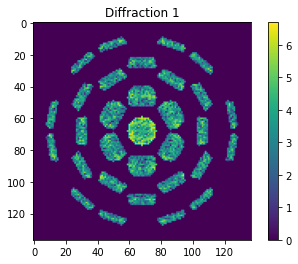

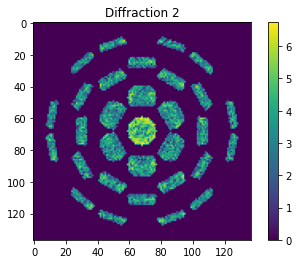

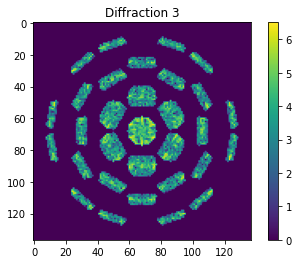

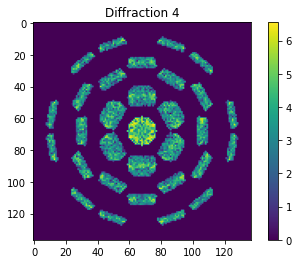

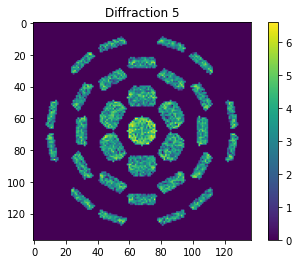

In [7]:
#this will display the random diffraction patterns
def nlogf(x):
    return np.log(1+1000*x)
nlog = np.vectorize(nlogf)
# /(np.array(random_diffs[0])).max()
# (np.array(random_diffs[0])).mean()
    
if Generate_random_diffs:
    
    
    #Mean=(np.array(random_diffs[0])).mean()
    #Std =(np.array(random_diffs[0])).std()
    
    plt.imshow(nlogf(np.array(random_diffs[0]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 1")
    plt.colorbar()
    plt.show()

    plt.imshow(nlogf(np.array(random_diffs[1]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 2")
    plt.colorbar()
    plt.show()

    plt.imshow(nlogf(np.array(random_diffs[2]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 3")
    plt.colorbar()
    plt.show()
    
    plt.imshow(nlogf(np.array(random_diffs[3]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 4")
    plt.colorbar()
    plt.show()
    
    plt.imshow(nlogf(np.array(random_diffs[4]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 5")
    plt.colorbar()
    plt.show()
    
else:
    plt.imshow(nlogf(np.array(diff_pattern[0]).reshape(detectorNx, detectorNy)))
    plt.title("Diffraction 1")
    plt.colorbar()
    plt.show()

In [8]:
# save the training data or experimental data
name = file
if Generate_random_diffs:
    print("type and shape of UgLists: ", np.array(Ug_normalized_matrix).dtype, np.array(Ug_normalized_matrix).shape)
    np.savetxt(trainingFolder + "/My_labels_" + name + ".csv", np.asarray(Ug_normalized_matrix))
    np.savetxt(trainingFolder + "/My_thickness_" + name + ".csv", np.asarray(random_thickness))
    np.savetxt(trainingFolder + "/random_diffs_" + name + ".csv", np.asarray(random_diffs))
    
    random_diffs_array = []
    for j in range(N_training_data):
        random_diffs_array.append(nlogf(np.array(random_diffs[j]).reshape(detectorNx, detectorNy)))
    random_diffs_array = np.asarray(random_diffs_array)
    print("shape of random pattern: ", random_diffs_array.shape)
    random_diffs_array_reshaped = random_diffs_array.reshape(len(random_diffs_array),-1)
    np.savetxt(trainingFolder + "/My_origin_features_" + name + ".csv", random_diffs_array_reshaped)
    print("type and shape of random pattern array:", np.array(random_diffs_array_reshaped).dtype,np.array(random_diffs_array_reshaped).shape)
    
else:
    np.savetxt(trainingFolder + "/diff_pattern_" + name + ".csv", np.asarray(diff_pattern))
    diff_pattern_array = nlogf(np.array(diff_pattern).reshape(detectorNx, detectorNy))
    print("shape of experimental pattern: ", diff_pattern_array.shape)
    diff_pattern_array_reshaped = diff_pattern_array.reshape(1,-1)
    np.savetxt(trainingFolder + "/My_simulation_pattern_" + name + ".csv", diff_pattern_array_reshaped)
    print("type and shape of experimental pattern array:",np.array(diff_pattern_array_reshaped).dtype,np.array(diff_pattern_array_reshaped).shape)

type and shape of UgLists:  complex128 (140, 97)
shape of random pattern:  (140, 137, 137)
type and shape of random pattern array: float64 (140, 18769)
